In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
# cluster 77 came from z ~25
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_smoothed, fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            raw_smoothed, interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object
            self.fictrac[short] = raw_smoothed

    def make_walking_vector(self):
        self.fictrac['W'] = np.zeros(len(self.fictrac['Y']))
        YZ = np.sqrt(np.power(self.fictrac['Y']/np.std(self.fictrac['Y']),2),
             np.power(self.fictrac['Z']/np.std(self.fictrac['Z']),2))
        self.fictrac['W'][np.where(YZ>.2)] = 1

        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)
        self.fictrac['Wi'] = interp1d(x_original, self.fictrac['W'], bounds_error = False, kind = 'nearest')

In [5]:
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()
    flies[fly].fictrac.make_walking_vector()


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 59.48 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.32 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 49.97 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.46 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 63.99 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.45 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 50.64 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.48 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 51.94 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.54 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.02

In [6]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [7]:
#width = 120000 #in ms, 2min
width = 30000 #in ms

step = 20 #in ms
time_shifts = list(range(-width,width,step))
xs = np.asarray(time_shifts)/1000

In [9]:
185, 77, 227, 141, 186 #very early inhibition
93,  27, 240, 116, 106, 204 #very early excititation

(93, 27, 240, 116, 106, 204)

In [8]:
behavior_i = 'Zi'
z=25

all_behavior_shifts = []
for fly in fly_names:
    interp_obj = flies[fly].fictrac.fictrac[behavior_i]
    behavior_shifts = []
    for shift in time_shifts:
        fictrac_interp = interp_obj(flies[fly].timestamps[:,z]+shift)
        fictrac_interp = np.nan_to_num(fictrac_interp)
        behavior_shifts.append(fictrac_interp)
    all_behavior_shifts.append(np.asarray(behavior_shifts))
all_behavior_shifts = np.asarray(all_behavior_shifts)

X = np.reshape(np.moveaxis(all_behavior_shifts,0,1),(-1,30456))
X.shape

(3000, 30456)

In [9]:
#########################
### fuse IPS clusters ###
#########################

#clusters = [57,77,185,186] #IPS
#clusters = [27,248,243] #LH OG
clusters = [27,243,11,12] #new LH

### all flies
Y = np.mean(supercluster_signals[clusters,:],axis=0)
cluster_response_77_L = np.dot(np.clip(X,0,None),Y)
cluster_response_77_R = np.dot(np.clip(X,None,0)*-1,Y)

clusters = [i+250 for i in clusters]
Y = np.mean(supercluster_signals[clusters,:],axis=0)
cluster_response_327_L = np.dot(np.clip(X,0,None),Y)
cluster_response_327_R = np.dot(np.clip(X,None,0)*-1,Y)

In [18]:
### all flies
cluster = 27#77
Y = supercluster_signals[cluster,:]
cluster_response_77_L = np.dot(np.clip(X,0,None),Y)
cluster_response_77_R = np.dot(np.clip(X,None,0)*-1,Y)

cluster += 250
Y = supercluster_signals[cluster,:]
cluster_response_327_L = np.dot(np.clip(X,0,None),Y)
cluster_response_327_R = np.dot(np.clip(X,None,0)*-1,Y)

In [11]:
### fly 087
cluster = 77
Y = supercluster_signals[cluster,:3384]
cluster_response_77_L = np.dot(np.clip(X[:,:3384],0,None),Y)
cluster_response_77_R = np.dot(np.clip(X[:,:3384],None,0)*-1,Y)

cluster += 250
Y = supercluster_signals[cluster,:3384]
cluster_response_327_L = np.dot(np.clip(X[:,:3384],0,None),Y)
cluster_response_327_R = np.dot(np.clip(X[:,:3384],None,0)*-1,Y)

In [15]:
### fly 087
#clusters = [27,248,243] #LH
clusters = [27,243,11,12]

Y = np.mean(supercluster_signals[clusters,:3384],axis=0)
cluster_response_77_L = np.dot(np.clip(X[:,:3384],0,None),Y)
cluster_response_77_R = np.dot(np.clip(X[:,:3384],None,0)*-1,Y)

clusters = [i+250 for i in clusters]
Y = np.mean(supercluster_signals[clusters,:3384],axis=0)
cluster_response_327_L = np.dot(np.clip(X[:,:3384],0,None),Y)
cluster_response_327_R = np.dot(np.clip(X[:,:3384],None,0)*-1,Y)

In [16]:
1

1

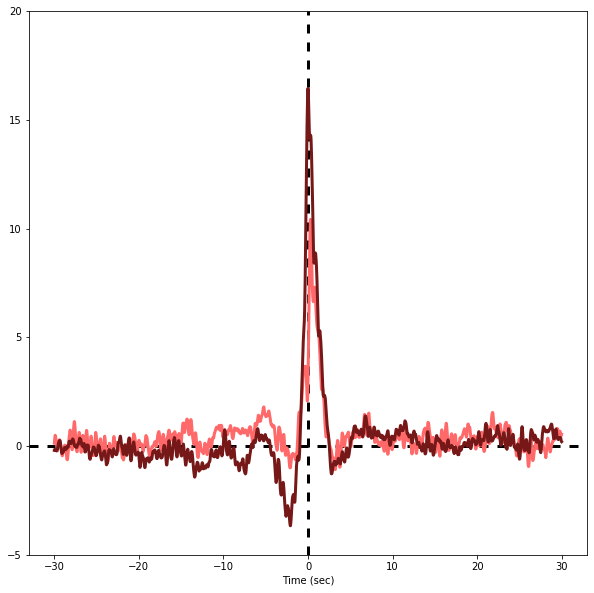

In [129]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)

# plt.plot(xs,cluster_response_77_L[::-1],color='#0C4F14',lw=3)
# plt.plot(xs,cluster_response_327_L[::-1],color='#08FF25',lw=3)
# plt.xlabel('Time (sec)')
# plt.ylim(-5,20)

plt.plot(xs,cluster_response_77_R[::-1],color='#FF6969',lw=3)
plt.plot(xs,cluster_response_327_R[::-1],color='#771818',lw=3)
plt.xlabel('Time (sec)')
plt.ylim(-5,20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

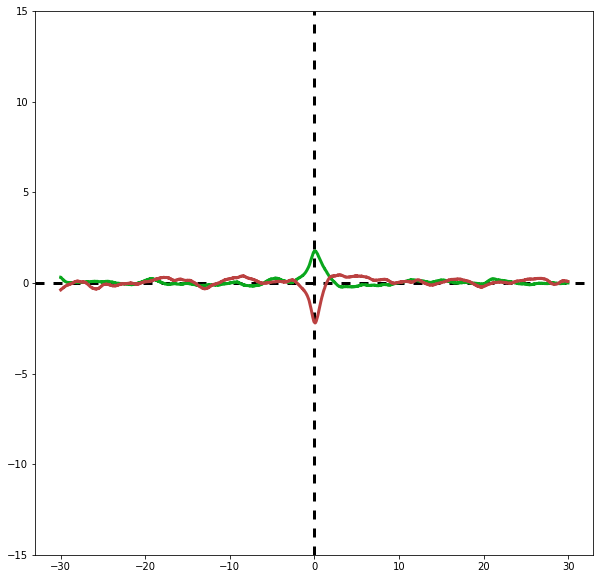

In [17]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)
L_diff = signal.filtfilt(b_notch, a_notch, cluster_response_77_L[::-1]-cluster_response_327_L[::-1])
R_diff = signal.filtfilt(b_notch, a_notch, cluster_response_77_R[::-1]-cluster_response_327_R[::-1])
plt.plot(xs,L_diff,color='#0AA71D',lw=3) #green
plt.plot(xs,R_diff,color='#BB4141',lw=3) #red
plt.ylim(-15,15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [50]:
# R_auto = np.load(os.path.join(cluster_dir,'20230306_R_autocorr.npy'))
# L_auto = np.load(os.path.join(cluster_dir,'20230306_L_autocorr.npy'))
turn_auto = np.load(os.path.join(cluster_dir,'20230306_turn_autocorr.npy'))

In [18]:
len(turn_L)

3000

In [13]:

turn_L = np.load(os.path.join(cluster_dir,'20230421_L_triggered_fly087.npy'))
turn_R = np.load(os.path.join(cluster_dir,'20230421_R_triggered_fly087.npy'))

In [10]:
turn_L = np.load(os.path.join(cluster_dir,'20230306_L_triggered_all.npy'))
turn_R = np.load(os.path.join(cluster_dir,'20230306_R_triggered_all.npy'))

In [11]:
turn_L -= np.mean(turn_L[:500])
turn_R -= np.mean(turn_R[:500])

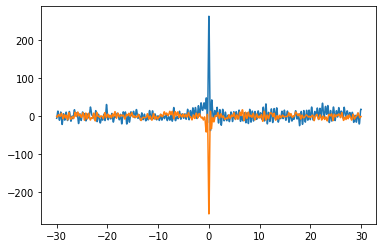

In [15]:
plt.plot(xs,turn_L)
plt.plot(xs,turn_R)
#plt.plot(turn_auto)

In [38]:
temp = np.load(os.path.join(cluster_dir,'20230328_bout_triggered2.npy'))
L_diff_trig = temp[0,:]
R_diff_trig = temp[1,:]

In [34]:
temp = np.load(os.path.join(cluster_dir,'20230328_bout_triggered.npy'))
L_diff_trig = temp[0,:]
R_diff_trig = temp[1,:]

In [35]:
x_OG = np.arange(-30000,30000,100)/1000
L_diff_trig_interp = interp1d(x_OG, L_diff_trig, bounds_error = False)(xs)
R_diff_trig_interp = interp1d(x_OG, R_diff_trig, bounds_error = False)(xs)


In [26]:
x_OG = np.arange(-30000,30000,100)/1000
len(x_OG)

600

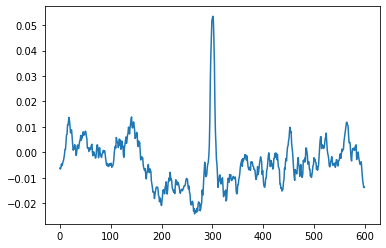

In [20]:
plt.plot(L_diff_trig)

(-8, 8)

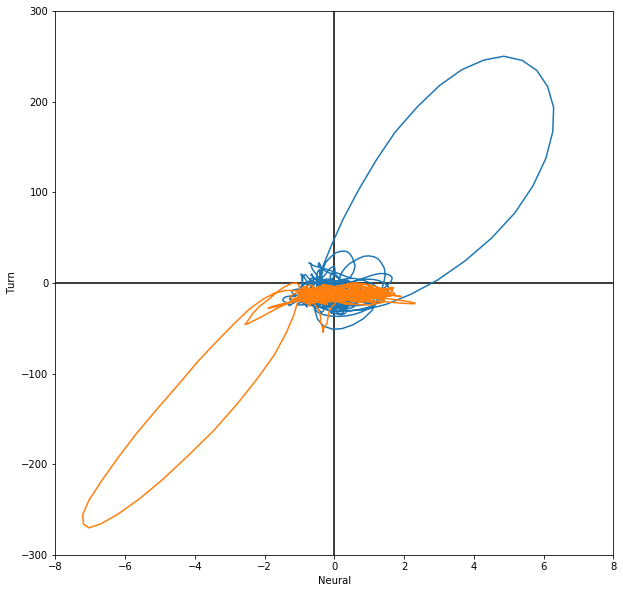

In [22]:
plt.figure(figsize=(10,10))
plt.axvline(0,color='k')
plt.axhline(0,color='k')
start = 0
stop = 1800
plt.plot(L_diff[start:stop],turn_L[start:stop])
plt.plot(R_diff[start:stop],turn_R[start:stop])
plt.ylabel('Turn')
plt.xlabel('Neural')
plt.ylim(-300,300)
plt.xlim(-8,8)

In [39]:
xs[800], xs[1100]

(-14.0, -8.0)

In [83]:
xs[1400], xs[1480], xs[1520], xs[1800], xs[2250]

(-2.0, -0.4, 0.4, 6.0, 15.0)

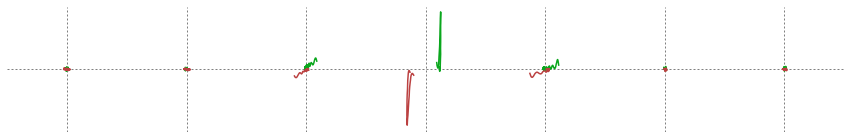

In [18]:
plt.figure(figsize=(15,2.3))

starts = [0,750,1100,1480,1520,1900,2250]
stops = [750,1100,1480,1520,1900,2250,2999]
title = ['-30 to -15 sec',
         '-14 to -8 sec',
         '-2 to 2 sec',
         '4 to 12 sec']

for i in range(7):
    plt.subplot(1,7,i+1)
    #plt.axvline(0,color='k')
    #plt.axhline(0,color='k')
    plt.axvline(0,color='grey',linestyle=(0,(2,2)),lw=1)
    plt.axhline(0,color='grey',linestyle=(0,(2,2)),lw=1)
    start = starts[i]
    stop = stops[i]
    plt.plot(L_diff[start:stop],turn_L[start:stop],lw=1.5,color='#0AA71D')
    plt.plot(R_diff[start:stop],turn_R[start:stop],lw=1.5,color='#BB4141')
    plt.ylabel('Turn')
    plt.xlabel('Neural Diff')
    plt.ylim(-300,300)
    #plt.xlim(-.07,.07)
    plt.xlim(-7,7)
    #plt.title(F'{xs[starts][i], xs[stops][i]}')
    plt.axis('off')
plt.subplots_adjust(wspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# vector field???

In [ ]:
# need bout version


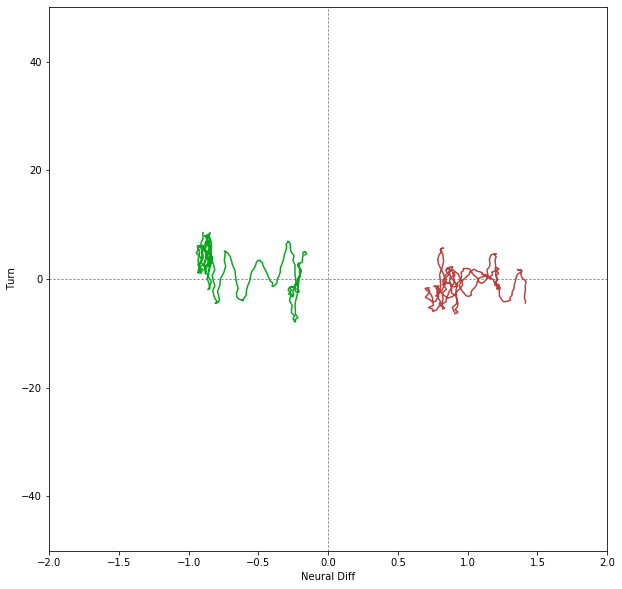

In [106]:
plt.figure(figsize=(10,10))



i=1
plt.axvline(0,color='grey',linestyle=(0,(2,2)),lw=1)
plt.axhline(0,color='grey',linestyle=(0,(2,2)),lw=1)
# start = starts[i]
# stop = stops[i]

start = 750
stop = 1100

plt.plot(L_diff[start:stop],turn_L[start:stop],lw=1.5,color='#0AA71D')
plt.plot(R_diff[start:stop],turn_R[start:stop],lw=1.5,color='#BB4141')
plt.ylabel('Turn')
plt.xlabel('Neural Diff')
plt.ylim(-50,50)
plt.xlim(-2,2)
#plt.title(F'{xs[starts][i], xs[stops][i]}')
#plt.axis('off')
plt.subplots_adjust(wspace=0)


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

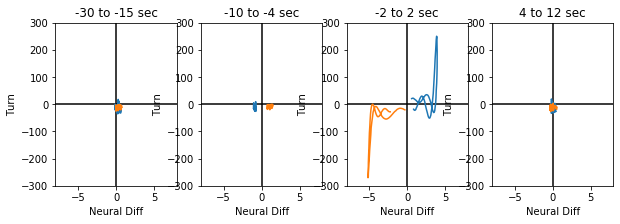

In [18]:
plt.figure(figsize=(10,3))

starts = [0,1000,1450,1700]
stops = [750,1300,1550,2100]
title = ['-30 to -15 sec',
         '-10 to -4 sec',
         '-2 to 2 sec',
         '4 to 12 sec']

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    start = starts[i]
    stop = stops[i]
    plt.plot(L_diff[start:stop],turn_L[start:stop])
    plt.plot(R_diff[start:stop],turn_R[start:stop])
    plt.ylabel('Turn')
    plt.xlabel('Neural Diff')
    plt.ylim(-300,300)
    plt.xlim(-8,8)
    plt.title(title[i])

In [32]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [35]:
L_diff_notched = signal.filtfilt(b_notch, a_notch, L_diff)
R_diff_notched = signal.filtfilt(b_notch, a_notch, R_diff)


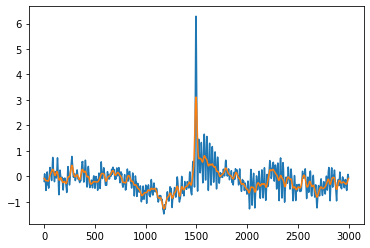

In [43]:
L_diff_smo = gaussian_filter1d(L_diff,sigma=10,truncate=2)
plt.plot(L_diff)
plt.plot(L_diff_smo)

In [48]:
L_diff_smo = gaussian_filter1d(L_diff,sigma=10,truncate=2)
R_diff_smo = gaussian_filter1d(R_diff,sigma=10,truncate=2)

turn_L_smo = gaussian_filter1d(turn_L,sigma=10,truncate=2)
turn_R_smo = gaussian_filter1d(turn_R,sigma=10,truncate=2)


In [25]:
from mpl_toolkits import mplot3d

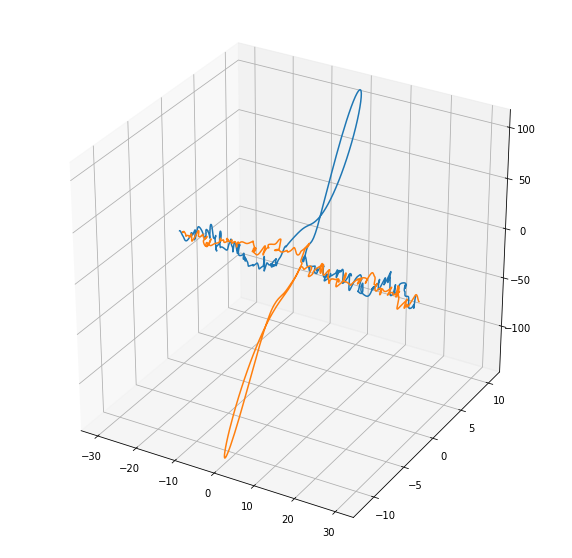

In [49]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(xs, L_diff_smo, turn_L_smo)
ax.plot3D(xs, R_diff_smo, turn_R_smo)

In [ ]:
### 3D ###

plt.figure(figsize=(10,10))
plt.axvline(0,color='k')
plt.axhline(0,color='k')
start = 0
stop = 1800
plt.plot(L_diff[start:stop],turn_L[start:stop])
plt.plot(R_diff[start:stop],turn_R[start:stop])
plt.ylabel('Turn')
plt.xlabel('Neural')
plt.ylim(-300,300)
plt.xlim(-8,8)

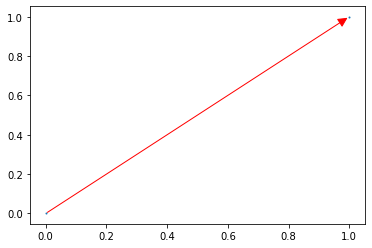

In [67]:
ax = plt.gca()
points = ax.scatter([0,1], [0,1], s=1)
arrow = mpl.patches.FancyArrowPatch(posA=(0,0), posB=(1,1), 
                                    arrowstyle='-|>', mutation_scale=20,color='r')
ax.add_patch(arrow)